In [1]:
from model import load_as_trt_model
from rchess import Board, Move
from utils import FakeTRTFunc
import numpy as np
from configs import engineplayConfig, selfplayConfig
from mcts import MCTS, debug_search, Node

use_fake = False
if use_fake:
    trt_func = FakeTRTFunc()
else:
    trt_func, _ = load_as_trt_model("latest")


2025-05-24 13:07:47.037156: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [2]:
mctsSearch = MCTS(engineplayConfig)
#mctsSearch = MCTS(selfplayConfig)

In [3]:
from chess import Board as PyBoard
board = Board()
board.push_uci("e2e4")
board.push_uci("e7e5")
board.push_uci("g1f3")
board.push_uci("b8c6")
#board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
#board = Board("6k1/8/8/3P4/8/8/8/K7 b - - 0 1")
#board = Board("2k5/5pn1/4P3/8/5Kn1/8/3R4/8 b - - 0 56")
pyBoard = PyBoard(board.fen())
#print(board)

In [79]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 0, 2.5, True)
debug_search(board, root, 3, 10)
board.push_num(move)
move_uci = Move(move).uci()
pyBoard.push_uci(move_uci)


  +---+---+---+---+---+---+---+---+
  | r |   |   |   |   |   |   | r | 8
  +---+---+---+---+---+---+---+---+
  |   | p | p |   | k | p | p | p | 7
  +---+---+---+---+---+---+---+---+
  | p |   |   | b |   |   |   |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  | P |   |   |   |   |   |   |   | 3
  +---+---+---+---+---+---+---+---+
  |   | P |   |   |   | P | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   | R | K | R |   |   |   |   | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r6r/1pp1kppp/p2b4/8/2P5/P7/1P3PPP/1RKR4 b - - 4 21
Key: 1130243a58398735
Elapsed time: 2.50s
Total visits: 23638
--------------------------------------------------------------------------------------------------------------
PV:
1. 0.756817 | a8d8 c1c2 d6h2 d1h1 h2f4 h1d1 g7g5 b2b3 e7e6
2. 0.730363 | h8d8 h2h3 d6c5 d1e1 e7f8 c1c2 

Move.from_uci('a8d8')

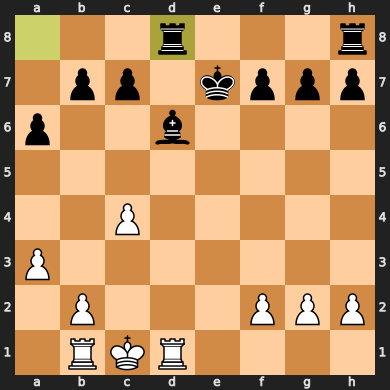

In [80]:
pyBoard

In [29]:
from model import predict_fn
board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
image, hash = board.history(engineplayConfig["history_perspective_flip"])
value, policies = predict_fn(trt_func, np.array([image]))
print("Value:", value.numpy())
print("Policies:", policies.numpy())
# Max of policies and min of policies
policies = policies.numpy()[0]
print("Max policy:", np.max(policies))
print("Min policy:", np.min(policies))
print("Mean policy:", np.mean(policies))

Value: [[0.00239372]]
Policies: [[ 0.73828125  0.9121094   0.81933594 ... -0.3786621   0.89160156
   1.0566406 ]]
Max policy: 1.5595703
Min policy: -0.8125
Mean policy: 0.0023056436


In [1]:
from time_control import UniversalTimeControl

print("=== Bullet Chess: 60s start, 0 increment ===")
tc = UniversalTimeControl(moves_estimate=100, move_overhead_ms=50)

examples = []
remaining_time = 60000  # Start with 60 seconds in ms
for move_num in range(1, 101, 1):
    move_time = tc.get_move_time(
        remaining_time_ms=remaining_time,
        increment_ms=0,
        has_pondered_ms=0,
        move_num=move_num
    )
    print(f"Move {move_num:3d}: remaining={remaining_time/1000:.2f}s, move_time={move_time:.3f}s")
    # Subtract the move time (converted to ms) for next iteration
    remaining_time -= int(move_time * 1000)
    if remaining_time < 0:
        remaining_time = 0

print("\n=== Bullet Chess: 60s start, 1s increment ===")
tc = UniversalTimeControl(moves_estimate=100, move_overhead_ms=50)

remaining_time = 60000  # Reset to 60 seconds
for move_num in range(1, 101, 1):
    move_time = tc.get_move_time(
        remaining_time_ms=remaining_time,
        increment_ms=1000,
        has_pondered_ms=0,
        move_num=move_num
    )
    print(f"Move {move_num:3d}: remaining={remaining_time/1000:.2f}s, move_time={move_time:.3f}s")
    # Subtract the move time, add increment for next iteration
    remaining_time = remaining_time - int(move_time * 1000 ) + 1000
    if remaining_time < 0:
        remaining_time = 0

=== Bullet Chess: 60s start, 0 increment ===
Move   1: remaining=60.00s, move_time=0.706s
Move   2: remaining=59.29s, move_time=0.708s
Move   3: remaining=58.59s, move_time=0.710s
Move   4: remaining=57.88s, move_time=0.711s
Move   5: remaining=57.17s, move_time=0.713s
Move   6: remaining=56.45s, move_time=0.714s
Move   7: remaining=55.74s, move_time=0.716s
Move   8: remaining=55.02s, move_time=0.717s
Move   9: remaining=54.31s, move_time=0.718s
Move  10: remaining=53.59s, move_time=0.720s
Move  11: remaining=52.87s, move_time=0.721s
Move  12: remaining=52.15s, move_time=0.722s
Move  13: remaining=51.43s, move_time=0.722s
Move  14: remaining=50.71s, move_time=0.723s
Move  15: remaining=49.98s, move_time=0.724s
Move  16: remaining=49.26s, move_time=0.725s
Move  17: remaining=48.54s, move_time=0.725s
Move  18: remaining=47.81s, move_time=0.725s
Move  19: remaining=47.09s, move_time=0.726s
Move  20: remaining=46.36s, move_time=0.726s
Move  21: remaining=45.64s, move_time=0.726s
Move  22: 

[74.5, 73.459, 72.426, 71.40100000000001, 70.384, 69.375, 68.374, 67.381, 66.396, 65.419, 64.45, 63.489000000000004, 62.536, 61.591, 60.653999999999996, 59.725, 58.804, 57.891000000000005, 56.986000000000004, 56.089, 55.2, 54.319, 53.446, 52.581, 51.724000000000004, 50.875, 50.034, 49.20099999999999, 48.376000000000005, 47.559, 46.75, 45.949, 45.156, 44.370999999999995, 43.593999999999994, 42.824999999999996, 42.064, 41.311, 40.566, 39.829, 39.1, 38.379, 37.666, 36.961, 36.263999999999996, 35.575, 34.894, 34.221000000000004, 33.556, 32.899, 32.25, 31.609, 30.976, 30.351, 29.734, 29.125, 28.524, 27.931, 27.346, 26.769, 26.200000000000003, 25.639, 25.086, 24.541, 24.004, 23.475, 22.954, 22.441, 21.936, 21.439, 20.95, 20.469, 19.996, 19.531, 19.073999999999998, 18.625, 18.184, 17.750999999999998, 17.326, 16.909, 16.5, 16.099, 15.706, 15.321, 14.943999999999999, 14.575, 14.213999999999999, 13.861, 13.516, 13.179, 12.85, 12.529, 12.216000000000001, 11.911, 11.614, 11.325, 11.044, 10.771, 10

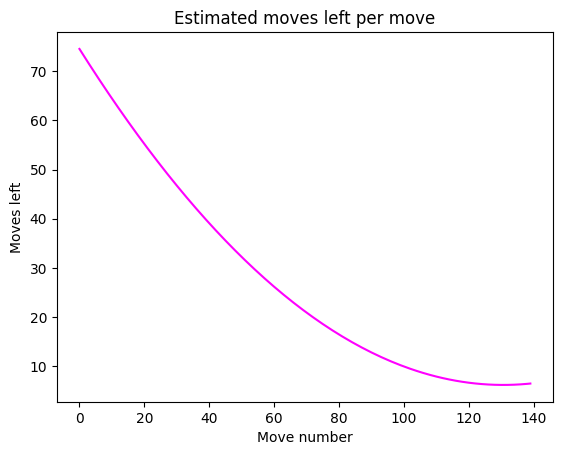

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def moves_left(move_num):
    a = 0.004
    b = -0.245
    h = 100
    k = 10
    return a * (move_num - h)**2 + b * (move_num - h) + k

x = np.arange(0, 140)
y = [moves_left(m) for m in x]
print(y)
plt.plot(x, y, color='magenta')
plt.xlabel("Move number")
plt.ylabel("Moves left")
plt.title("Estimated moves left per move")
plt.show()